# Beer style prediction

## Set up environment

In [1]:
# Import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump
from joblib import load
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
os.getcwd()

'C:\\Users\\David Anker\\Documents\\MDSI\\adsi\\projects\\adsi_at2\\notebooks'

In [3]:
os.chdir('../')
os.getcwd()

'C:\\Users\\David Anker\\Documents\\MDSI\\adsi\\projects\\adsi_at2'

## Get data

In [4]:
# Load magic command for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [5]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import data
df = pd.read_csv("./data/raw/beer_reviews.csv")

# Check data
display(df)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


## Check data

In [6]:
# Generate Data Dictionary
# Direct copy & paste from Assignment 2 Brief

DataDict = \
    { "brewery_id": "Identifier of brewery"
    , "brewery_name": "Name of brewery"
    , "review_time": "Timestamp of review"
    , "review_overall": "Overall score given by reviewer"
    , "review_aroma": "Score given by reviewer regarding beer aroma"
    , "review_appearance": "Score given by reviewer regarding beer appearance"
    , "review_profilename": "Profile name of reviewer"
    , "review_palate": "Score given by reviewer regarding beer palate"
    , "review_taste": "Score given by reviewer regarding beer taste"
    , "beer_style (target)": "Type of beer"
    , "beer_name": "Name of beer"
    , "beer_abv": "Alcohol by volume measure"
    , "beer_beerid": "Identifier of beer"
    }

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [8]:
df.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06,1.586614e+06
mean,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00,2.181834e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.717000e+03
50%,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.390600e+04
75%,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


In [9]:
# View data profile

# Create profile report
profile = ProfileReport(df, title="Profile Report", minimal=True)
# Export
profile.to_file('./reports/InitialReport.html')
# View
#profile

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Identify any null values by variable
print(df.isnull().sum())

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64


In [11]:
# Identify any duplicate observations (ie same reviewer rating the same beer multiple times)
df_dupe = df.sort_values('review_overall', ascending=False)
df_dupe = df_dupe.drop_duplicates(['review_profilename', 'beer_name'], keep='first')
print('Duplicates:',len(df)-len(df_dupe))

Duplicates: 24882


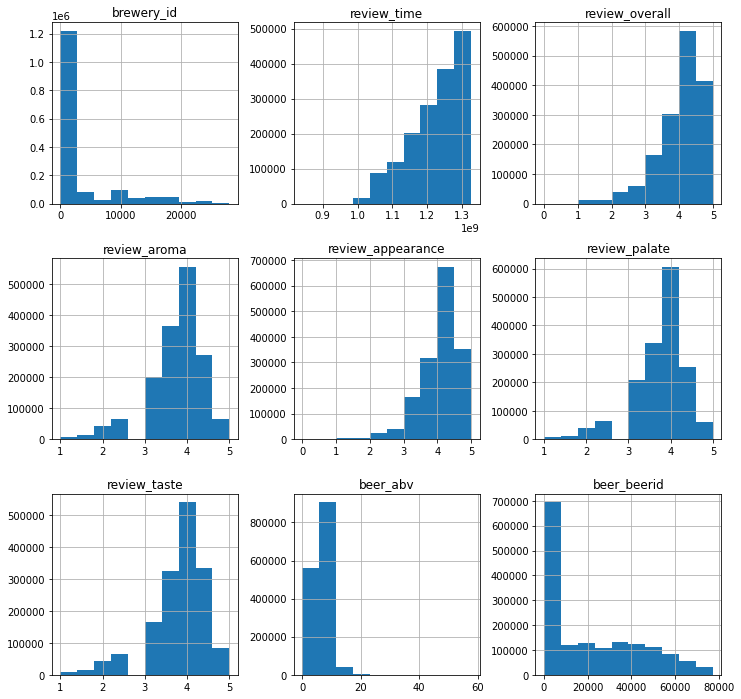

In [12]:
# Show distribution of numerical variables
import matplotlib.pyplot as plt

df.hist(figsize=(12,12))
plt.show()

In [15]:
# Reviewers
df.value_counts(['review_profilename']).reset_index(name='reviews')

,review_profilename,reviews
0,northyorksammy,5817
1,BuckeyeNation,4661
2,mikesgroove,4617
3,Thorpe429,3518
4,womencantsail,3497
...,...,...
33382,clwaldin,1
33383,cm1165,1
33384,cmartin45,1
33385,cmaude,1


In [16]:
# Brewery name count
df.value_counts(['brewery_name']).reset_index(name='reviews')

,brewery_name,reviews
0,Boston Beer Company (Samuel Adams),39444
1,Dogfish Head Brewery,33839
2,Stone Brewing Co.,33066
3,Sierra Nevada Brewing Co.,28751
4,"Bell's Brewery, Inc.",25191
...,...,...
5737,Science Infuse,1
5738,Bir&#371; Alus,1
5739,Birrificio Valscura,1
5740,Calwer-Eck-Bräu GmbH & Co. KG,1


In [17]:
# Beer_styles per brewery
df.groupby('brewery_name')['beer_style'].nunique().reset_index(name='beer_style count').sort_values(by='beer_style count', ascending=False)

,brewery_name,beer_style count
4473,Rock Bottom Restaurant & Brewery,86
2960,John Harvard's Brewery & Ale House,83
2885,Iron Hill Brewery & Restaurant,83
2417,Goose Island Beer Co.,67
402,Beer Works,67
...,...,...
813,Brasserie Des Monts,1
4792,Smolenskoye Pivo,1
4790,Smokehouse Winery,1
3614,Mill Creek Brewpub,1


In [19]:
# Summary table by beer_style target class

# Beers per beer_style
df_beers = df[['beer_name', 'brewery_name', 'beer_style', 'beer_abv']].drop_duplicates()
beers = df_beers.value_counts(['beer_style']).reset_index(name='beer_count')

# Breweries per beer_style
breweries = df.groupby('beer_style')['brewery_name'].nunique().reset_index(name='brewery count')

# Reviews per beer_style
reviews = df.groupby('beer_style')['review_overall'].count().reset_index(name='review_count')

# Reviewers per beer_style
reviewers = df.groupby('beer_style')['review_profilename'].nunique().reset_index(name='reviewer_count')

# Average review_overall per beer_style
avg = df.groupby('beer_style')['review_overall'].mean().reset_index(name='avg review_overall')

# Merged dataframe
beer_style_summary = beers.merge(right=breweries, how='left', on='beer_style')
beer_style_summary = beer_style_summary.merge(right=reviews, how='left', on='beer_style')
beer_style_summary = beer_style_summary.merge(right=reviewers, how='left', on='beer_style')
beer_style_summary = beer_style_summary.merge(right=avg, how='left', on='beer_style')
beer_style_summary

,beer_style,beer_count,brewery count,review_count,reviewer_count,avg review_overall
0,American IPA,3599,1606,117586,12480,3.965221
1,American Pale Ale (APA),3330,1691,63469,9252,3.852306
2,American Amber / Red Ale,2500,1478,45751,8337,3.781010
3,American Porter,2188,1222,50477,8464,3.895735
4,Fruit / Vegetable Beer,1833,1014,33861,7336,3.415124
...,...,...,...,...,...,...
99,Kvass,44,25,297,157,3.355219
100,Gose,33,25,686,551,3.965015
101,Sahti,28,21,1061,832,3.700283
102,Bière de Champagne / Bière Brut,20,13,1046,815,3.648184


In [20]:
# Assess target class balance
# Adapted from https://stackoverflow.com/questions/50169311/getting-percentage-and-count-python
pd.concat([df.value_counts(['beer_style']), df.value_counts(['beer_style'], normalize=True).mul(100)],axis=1, keys=('count','%'))

,count,%
beer_style,,
American IPA,117586,7.411128
American Double / Imperial IPA,85977,5.418898
American Pale Ale (APA),63469,4.000280
Russian Imperial Stout,54129,3.411605
American Double / Imperial Stout,50705,3.195799
...,...,...
Gose,686,0.043237
Faro,609,0.038384
Roggenbier,466,0.029371


## Prepare data

In [21]:
# Create a copy of df and save it into a variable called df_cleaned
df_cleaned = df.copy()

In [22]:
# Drop duplicates
df_cleaned = df_cleaned.sort_values('review_overall', ascending=False)
df_cleaned = df_cleaned.drop_duplicates(['review_profilename', 'beer_name'], keep='first')

In [23]:
# Drop NAs from relevant variables
df_cleaned = df_cleaned.dropna(subset=['brewery_name', 'review_profilename'])

In [24]:
# Drop variables not required
df_cleaned = df_cleaned.drop(['brewery_id', 'review_time', 'review_overall', 'review_profilename', 'beer_name', 'beer_abv', 'beer_beerid'], axis=1)

In [25]:
# Create a copy of df_cleaned and save it into a variable called df_encoded
df_encoded = df_cleaned.copy()

In [26]:
# Apply label encoder to 'beer_style' target variable
# Adapted from: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_cleaned['beer_style'])
df_encoded['beer_style'] = le.transform(df_encoded['beer_style'])

In [27]:
# Apply binary encoder to 'brewery_name' variable
from category_encoders.binary import BinaryEncoder

be = BinaryEncoder(cols=['brewery_name'])
be.fit(df_encoded)
df_encoded = be.transform(df_encoded)

c:\python37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [28]:
# Apply StandardScaler to all numerical input variables
# Adapted from: stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set
from sklearn.preprocessing import StandardScaler

# Create a copy of df_encoded and save it into a variable called df_enc_sc
df_enc_sc = df_encoded.copy()

col_names = df_encoded.columns.tolist()
col_names.remove('beer_style')
features = df_enc_sc[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_enc_sc[col_names] = features

In [29]:
# Split data into training and testing with 80-20 ratio
from src.data.sets import split_sets_random, save_sets, pop_target

X_train, y_train, X_val, y_val, X_test, y_test = split_sets_random(df_enc_sc, target_col='beer_style', test_ratio=0.2, to_numpy=True)

# Save sets to folder
save_sets(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, path='./data/processed/')

In [30]:
# Import PytorchDataset class and convert all sets
from src.models.pytorch import PytorchDataset

train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

## Baseline

In [31]:
# Import NullModel from src.models.null
from src.models.null import NullModel

In [32]:
# Instantiate NullModel and call .fit_predict() on the training target to extract predictions into a variable called y_base
baseline_model = NullModel(target_type='classification')
y_base = baseline_model.fit_predict(y_train)

In [33]:
# Print the classification metrics for this baseline model
from src.models.performance import print_class_perf

print_class_perf(y_base, y_train, set_name='Training', average='weighted')

Accuracy Training: 0.07332889284547743
F1 Training: 0.01001953187282294


## Define architecture

In [34]:
# Instantiate PytorchMultiClass and save it into a variable called model
from src.models.pytorch import PytorchMultiClass
model = PytorchMultiClass(X_train.shape[1])

In [35]:
# Set model to use the device available
from src.models.pytorch import get_device
device = get_device()
model.to(device)

PytorchMultiClass(
  (layer_1): Linear(in_features=18, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [36]:
# Print the architecture of model
print(model)

PytorchMultiClass(
  (layer_1): Linear(in_features=18, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Train model

In [37]:
# Instantiate a nn.CrossEntropyLoss() and save it into a variable called criterion
criterion = nn.CrossEntropyLoss()

In [38]:
# Instantiate a torch.optim.Adam() optimizer with the model's parameters and learning rate and save it into a variable called optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [39]:
# Import train_classification and test_classification functions that will perform forward and back propagation and calculate loss and Accuracy scores
from src.models.pytorch import train_classification, test_classification

In [40]:
# Define N_EPOCHS and BATCH_SIZE variables
N_EPOCHS = 5
BATCH_SIZE = 512

In [41]:
# Create variables to save accuracy and loss by epoch for plotting
train_loss_history = [] 
train_acc_history = []
valid_loss_history = []
valid_acc_history = []

In [42]:
# Create a for loop that will iterate through the specified number of epochs and will train the model with the training set and assess the performance on the validation set and print their scores
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)
    
    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
    print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

Epoch: 0
	(train)	|	Loss: 0.0089	|	Acc: 12.6%
	(valid)	|	Loss: 0.0088	|	Acc: 17.1%
Epoch: 1
	(train)	|	Loss: 0.0087	|	Acc: 19.1%
	(valid)	|	Loss: 0.0087	|	Acc: 21.2%
Epoch: 2
	(train)	|	Loss: 0.0087	|	Acc: 21.6%
	(valid)	|	Loss: 0.0087	|	Acc: 22.3%
Epoch: 3
	(train)	|	Loss: 0.0087	|	Acc: 22.5%
	(valid)	|	Loss: 0.0087	|	Acc: 23.1%
Epoch: 4
	(train)	|	Loss: 0.0087	|	Acc: 23.2%
	(valid)	|	Loss: 0.0086	|	Acc: 23.6%


### Resume training from checkpoint (if required)

In [43]:
# Save model checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            }, "./models/checkpoints/beer_pred_cpu.pt")

In [ ]:
# Load model from checkpoint
model = PytorchMultiClass(X_train.shape[1])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load("./models/checkpoints/beer_pred_cpu.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval() #OR
model.train()

## Assess performance

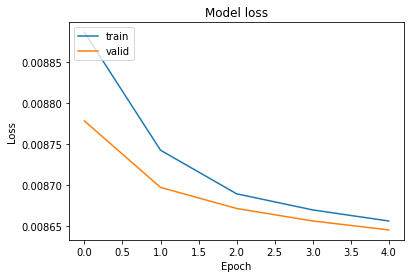

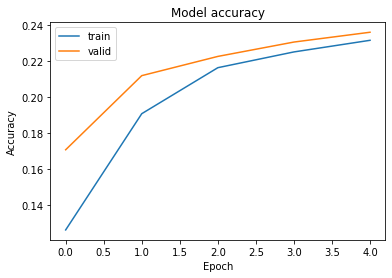

In [44]:
# Plot training and validation loss and accuracy per epoch
# Adapted from: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(train_acc_history)
plt.plot(valid_acc_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [45]:
# Assess the model performance on the testing set and print its scores
test_loss, test_acc = test_classification(test_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
print(f'\tLoss: {test_loss:.4f}\t|\tAcc: {test_acc:.1f}')

	Loss: 0.0086	|	Acc: 0.2


In [47]:
# Print predictions by (encoded) class
preds = model(test_dataset.X_tensor.to(device)).argmax(1)
df_preds = pd.DataFrame(preds)
df_preds.value_counts()

12     90720
9      42028
89     25072
11     18003
2      14591
60     14557
25     12464
14     11931
1      11037
47     10740
65     10324
53      8107
92      7848
37      5496
26      5135
76      4212
86      3923
74      3090
103     2398
102     2172
67      1992
94      1432
24      1322
79       956
58       673
98       654
96       489
44       348
42       312
36       252
dtype: int64

## Create artefacts for deployment

In [48]:
# Save model
torch.save(model, "./models/beer_pred_cpu.pt")
torch.save(model.state_dict(), "./models/beer_pred_cpu_state_dict.pt")

In [50]:
# Cleaned dataset with target variable removed 
df_prod = df_cleaned.copy()
df_prod.pop('beer_style')

793307             American Pale Ale (APA)
591801    American Double / Imperial Stout
591818    American Double / Imperial Stout
591819    American Double / Imperial Stout
591824    American Double / Imperial Stout
                        ...               
653706            American Amber / Red Ale
37234                       Czech Pilsener
653695                          Hefeweizen
39667              American Pale Ale (APA)
39648                      Irish Dry Stout
Name: beer_style, Length: 1561390, dtype: object

In [51]:
# Pipeline to transform data
from sklearn.pipeline import Pipeline

def create_pipe(df):

    pipe = Pipeline([
        ('be', BinaryEncoder(cols=['brewery_name'])),
        ('sc', StandardScaler())
    ])

    pipe.fit(df)

    return pipe

be_sc = create_pipe(df_prod)

dump(be_sc, './models/be_sc.joblib')

c:\python37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


['./models/be_sc.joblib']

In [52]:
# Label encoder
dump(le, './models/le.joblib')

['./models/le.joblib']

## Test artefacts for deployment

### Single beer_type prediction

In [53]:
# Load model and set to evaluation mode
model = torch.load('./models/beer_pred_cpu.pt')
model.eval()

PytorchMultiClass(
  (layer_1): Linear(in_features=18, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [54]:
# Create dummy dataframe to simulate app inputs
brewery_name = 'Vecchio Birraio'
review_aroma = 2.5
review_appearance = 1.5
review_palate = 1.5
review_taste = 1.5

input_df = pd.DataFrame({'brewery_name': [brewery_name],
                       'review_aroma': [review_aroma],
                       'review_appearance': [review_appearance],
                       'review_palate': [review_palate],
                       'review_taste': [review_taste]})

In [55]:
# Load artefacts, process and transform data, run through model, print predictions
be_sc = load('./models/be_sc.joblib')
input_df = be_sc.transform(input_df)
input_tensor = torch.Tensor(np.array(input_df))
pred_num = model(input_tensor).argmax(1)
le = load('./models/le.joblib')
pred_name = le.inverse_transform(pred_num.tolist())[0]
pred_name

'Euro Pale Lager'

### Multiple beer_type prediction

In [56]:
# Load model and set to evaluation mode
model = torch.load('./models/beer_pred_cpu.pt')
model.eval()

PytorchMultiClass(
  (layer_1): Linear(in_features=18, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [57]:
# Create dummy dataframe to simulate app inputs
brewery_names = ['Vecchio Birraio', 'Caldera Brewing Company']
reviews_aroma = [2.5, 1.5]
reviews_appearance = [1.5, 3.0]
reviews_palate = [1.5, 4.0]
reviews_taste = [1.5, 3.0]

input_df = pd.DataFrame({'brewery_name': brewery_names,
                       'review_aroma': reviews_aroma,
                       'review_appearance': reviews_appearance,
                       'review_palate': reviews_palate,
                       'review_taste': reviews_taste})

In [58]:
# Load artefacts, process and transform data, run through model, print predictions
be_sc = load('./models/be_sc.joblib')
input_df = be_sc.transform(input_df)
input_tensor = torch.Tensor(np.array(input_df))
pred_nums = model(input_tensor).argmax(1)
le = load('./models/le.joblib')
pred_names = list(le.inverse_transform(pred_nums.tolist()))
pred_names

['Euro Pale Lager', 'American IPA']

### Model architecture

In [97]:
from src.utils.misc import capture
#from torchsummary import summary

model = torch.load("./models/beer_pred_cpu.pt")

def display_architecture():
    with capture() as output:
        #print(summary(model, input_size=(1000,18)))
        print(model)
    return output

display_architecture()

['PytorchMultiClass(',
 '  (layer_1): Linear(in_features=18, out_features=1024, bias=True)',
 '  (layer_2): Linear(in_features=1024, out_features=512, bias=True)',
 '  (layer_3): Linear(in_features=512, out_features=128, bias=True)',
 '  (layer_4): Linear(in_features=128, out_features=64, bias=True)',
 '  (layer_out): Linear(in_features=64, out_features=104, bias=True)',
 '  (softmax): Softmax(dim=1)',
 '  (relu): ReLU()',
 '  (dropout): Dropout(p=0.3, inplace=False)',
 '  (batchnorm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)',
 '  (batchnorm_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)',
 '  (batchnorm_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)',
 '  (batchnorm_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)',
 ')']